In [2]:
from google.colab import drive
drive.mount('/content/drive')
#This will allow you to access your google drive contents from google colab notebook.
#put your Python files as .py files in a folder on your Google drive
#then execute
#drive.mount('/content/drive/<path_to_your_dir>')
#from <your lib(without .py)> import *

Mounted at /content/drive


In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=145ae9ed24e4592569bec041330a628fe06bbb162b6e81543bc34404c3ec71ec
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [4]:
import pyspark
import os
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import HiveContext
from pyspark.sql.session import *
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import QuantileDiscretizer, Bucketizer, StringIndexer, IndexToString

import pyspark.sql.functions as F
import pandas as pd
import numpy as np

#import pyarrow
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


spark = SparkSession.builder.master("local[*]")\
          .appName("SparkByExamples.com")\
          .getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=SparkByExamples.com>

In [5]:
from IPython.display import Image, display, Markdown
from IPython.core.display import HTML
display(HTML('<style = fonte-size>pre {white-space: pre !important; }</style>'))

**Steps Involved in NLP**

1. Reading the corpus (entire collection of text documents)

2. Tokenization

3. Cleaning/stopword removal

4. Stemming

5. Converting into numerical form






**Tokenization using PySpark**

In [6]:
%%time
from pyspark.ml.feature import Tokenizer

#creating the corpus, with four sentences for tokenization

df=spark.createDataFrame([(1,'I really liked this movie'),
(2,'I would recommend this movie to my friends'),
(3,'movie was alright but acting was horrible'),
(4,'I am never watching that movie ever again')],
['user_id','review'])


df.show(5,False)

tokenization=Tokenizer(inputCol='review',outputCol='tokens')
tokenized_df=tokenization.transform(df)
tokenized_df.show(4,False)

+-------+------------------------------------------+
|user_id|review                                    |
+-------+------------------------------------------+
|1      |I really liked this movie                 |
|2      |I would recommend this movie to my friends|
|3      |movie was alright but acting was horrible |
|4      |I am never watching that movie ever again |
+-------+------------------------------------------+

+-------+------------------------------------------+---------------------------------------------------+
|user_id|review                                    |tokens                                             |
+-------+------------------------------------------+---------------------------------------------------+
|1      |I really liked this movie                 |[i, really, liked, this, movie]                    |
|2      |I would recommend this movie to my friends|[i, would, recommend, this, movie, to, my, friends]|
|3      |movie was alright but acting was horrible

**Stopword Removal**

 Very common words such as “this,”
“the,” “to,” “was,” “that,” etc., are known as stopwords, and they seem to add very little value to the analysis. In PySpark, we use StopWordsRemover to remove the
stopwords

In [7]:
%%time
from pyspark.ml.feature import StopWordsRemover
stopword_removal = StopWordsRemover(inputCol='tokens',outputCol='refined_tokens')
refined_df = stopword_removal.transform(tokenized_df)
refined_df.select(['user_id','tokens','refined_tokens']).show(4,False)

+-------+---------------------------------------------------+----------------------------------+
|user_id|tokens                                             |refined_tokens                    |
+-------+---------------------------------------------------+----------------------------------+
|1      |[i, really, liked, this, movie]                    |[really, liked, movie]            |
|2      |[i, would, recommend, this, movie, to, my, friends]|[recommend, movie, friends]       |
|3      |[movie, was, alright, but, acting, was, horrible]  |[movie, alright, acting, horrible]|
|4      |[i, am, never, watching, that, movie, ever, again] |[never, watching, movie, ever]    |
+-------+---------------------------------------------------+----------------------------------+

CPU times: user 60.1 ms, sys: 1.33 ms, total: 61.4 ms
Wall time: 2.01 s


**Convert the tokens into a numerical form**

This is necessary because ML algorithms work with numerical data.

*Bag of words:*

Converts the text data into numerical vector
form by considering the occurrence of the words in text documents. The list of unique words appearing in all the documents is known as vocabulary. It is built a matrix where each row represents a document and each column a word of the vocabulary, assigning either 0 or 1 depending on the presence of the word in the document.

Bag of words does not consider the order of words in the document and the semantic
meaning of the word and hence is the most baseline method to represent the text data
in numerical form.

*CountVectorizer:*

The count vectorizer instead takes
the total count of the tokens appearing in the document.

In [8]:
%%time
from pyspark.ml.feature import CountVectorizer
count_vec=CountVectorizer(inputCol='refined_tokens',outputCol='features')
cv_df=count_vec.fit(refined_df).transform(refined_df)
cv_df.select(['user_id','refined_tokens','features']).show(4,False)

+-------+----------------------------------+--------------------------------+
|user_id|refined_tokens                    |features                        |
+-------+----------------------------------+--------------------------------+
|1      |[really, liked, movie]            |(11,[0,3,5],[1.0,1.0,1.0])      |
|2      |[recommend, movie, friends]       |(11,[0,2,10],[1.0,1.0,1.0])     |
|3      |[movie, alright, acting, horrible]|(11,[0,1,8,9],[1.0,1.0,1.0,1.0])|
|4      |[never, watching, movie, ever]    |(11,[0,4,6,7],[1.0,1.0,1.0,1.0])|
+-------+----------------------------------+--------------------------------+

CPU times: user 31.2 ms, sys: 2.86 ms, total: 34.1 ms
Wall time: 2.53 s


In [9]:
%%time
vocab = count_vec.fit(refined_df).vocabulary
print('words in vocabulary: ', len(vocab))
print(np.array(vocab)) #vocab[0]='movie'--> appears in all the documents

#the features column structure is like the input feature vector
#used for Machine Learning in PySpark.
#The drawback of using the CountVectorizer method is
#that it doesn’t consider the co-occurrences of words in other documents. In simple
#terms, the words appearing often would have larger impact on the feature vector.

words in vocabulary:  11
['movie' 'horrible' 'recommend' 'liked' 'never' 'really' 'ever' 'watching'
 'acting' 'alright' 'friends']
CPU times: user 15.6 ms, sys: 3.73 ms, total: 19.3 ms
Wall time: 1.56 s


**TF-IDF (Term
Frequency – Inverse Document Frequency)**

This method tries to normalize the frequency of token occurrence based on other
documents. The whole idea is to give more weight to the token if appearing high number
of times in the same document but penalize if it is appearing higher number of times in
other documents as well. This indicates that the token is common across the corpus and
is not as important as its frequency in the current document indicates.

*Term Frequency:* Score based on the frequency of the word in the current document.

*Inverse Document Frequency*: Score based on the number of documents that
contain the current word.

In [10]:
%%time

from pyspark.ml.feature import HashingTF, IDF

hashing_vec = HashingTF(inputCol='refined_tokens',outputCol='tf_features')#, numFeatures=100)
hashing_df = hashing_vec.transform(refined_df)
hashing_df.select(['user_id','refined_tokens','tf_features']).show(4,False)

#HashingTF converts documents to vectors of fixed size. The default feature dimension is 262,144.

+-------+----------------------------------+-------------------------------------------------------+
|user_id|refined_tokens                    |tf_features                                            |
+-------+----------------------------------+-------------------------------------------------------+
|1      |[really, liked, movie]            |(262144,[99172,210223,229264],[1.0,1.0,1.0])           |
|2      |[recommend, movie, friends]       |(262144,[68228,130047,210223],[1.0,1.0,1.0])           |
|3      |[movie, alright, acting, horrible]|(262144,[95685,171118,210223,236263],[1.0,1.0,1.0,1.0])|
|4      |[never, watching, movie, ever]    |(262144,[63139,113673,203802,210223],[1.0,1.0,1.0,1.0])|
+-------+----------------------------------+-------------------------------------------------------+

CPU times: user 13 ms, sys: 3.45 ms, total: 16.5 ms
Wall time: 1.39 s


In [11]:
%%time

tf_idf_vec=IDF(inputCol='tf_features',outputCol='tf_idf_features')
tf_idf_df=tf_idf_vec.fit(hashing_df).transform(hashing_df)
tf_idf_df.select(['user_id','tf_idf_features']).show(4,False)

#IDF(minDocFreq: int = 0)
#Inverse document frequency (IDF).
#The standard formulation is used: idf = log[(m + 1) / (d(t) + 1)],
#where m is the total number of documents
#and d(t) is the number of documents that contain term t.
#This implementation supports filtering out terms which do not appear
#in a minimum number of documents (controlled by the variable minDocFreq).
#For terms that are not in at least minDocFreq documents,
#the IDF is found as 0, resulting in TF-IDFs of 0.

+-------+----------------------------------------------------------------------------------------------------+
|user_id|tf_idf_features                                                                                     |
+-------+----------------------------------------------------------------------------------------------------+
|1      |(262144,[99172,210223,229264],[0.9162907318741551,0.0,0.9162907318741551])                          |
|2      |(262144,[68228,130047,210223],[0.9162907318741551,0.9162907318741551,0.0])                          |
|3      |(262144,[95685,171118,210223,236263],[0.9162907318741551,0.9162907318741551,0.0,0.9162907318741551])|
|4      |(262144,[63139,113673,203802,210223],[0.9162907318741551,0.9162907318741551,0.9162907318741551,0.0])|
+-------+----------------------------------------------------------------------------------------------------+

CPU times: user 39.9 ms, sys: 6.85 ms, total: 46.7 ms
Wall time: 5.91 s


**Text Classification Using Machine Learning**

Here we are going to use the IMDB Dataset from Kaggle.

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/download?datasetVersionNumber=1

In [12]:
%%time

filename = '/content/drive/MyDrive/colab_files/pyspark/imdb_dataset.csv'

text_df = spark.read.format('csv') \
              .option("inferSchema", False) \
              .option("header", True) \
              .option("sep", ',') \
              .option("quote", "\"")\
              .option("escape", "\"")\
              .load(filename)

text_df.show(5, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

If double-quotes are used to enclose fields, then a double-quote appearing inside a field must be escaped by preceding it with another double quote

That's what Excel does, for example, by default.

Although in Spark (as of Spark 2.1), escaping is done by default through non-RFC way, using backslah (\\). To fix this you have to explicitly tell Spark to use doublequote to use as an escape character:

.option("quote", "\\"")

.option("escape", "\\"")

This may explain that a comma character wasn't interpreted correctly as it was inside a quoted column.

Options for Spark csv format are not documented well on Apache Spark site, but here's a bit older documentation which can be useful quite often:

https://github.com/databricks/spark-csv

In [13]:
%%time

text_df.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
| positive|25000|
| negative|25000|
+---------+-----+

CPU times: user 18.5 ms, sys: 1.21 ms, total: 19.8 ms
Wall time: 2.89 s


In [14]:
%%time

from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_index",
                        stringOrderType="frequencyDesc").fit(text_df)

text_df = indexer.transform(text_df)
text_df.show(5, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
%%time

text_df.groupBy('sentiment', 'sentiment_index').count().show()

+---------+---------------+-----+
|sentiment|sentiment_index|count|
+---------+---------------+-----+
| negative|            0.0|25000|
| positive|            1.0|25000|
+---------+---------------+-----+

CPU times: user 9.61 ms, sys: 343 µs, total: 9.96 ms
Wall time: 1.27 s


In [16]:
%%time
print('Number of records: ', text_df.count())
text_df=text_df.filter(((text_df.sentiment_index ==1.0) | (text_df.sentiment_index ==0.0)))
print('Records labeled correctly: ', text_df.count())

Number of records:  50000
Records labeled correctly:  50000
CPU times: user 14 ms, sys: 1.11 ms, total: 15.1 ms
Wall time: 1.73 s


In [17]:
%%time
#include an additional column that captures the length of the review

text_df = text_df.withColumn('length',F.length(text_df['review']))
text_df.orderBy(F.rand()).show(10)

print('Mean length of reviews per sentiment type')
text_df.groupBy('sentiment_index').agg({'length':'mean'}).show()

+--------------------+---------+---------------+------+
|              review|sentiment|sentiment_index|length|
+--------------------+---------+---------------+------+
|Del - "You are th...| negative|            0.0|   752|
|I haven't seen ma...| negative|            0.0|   681|
|Everyone involved...| negative|            0.0|   731|
|While this isn't ...| negative|            0.0|  1575|
|the only scenes w...| negative|            0.0|   601|
|Undoubtedly one o...| positive|            1.0|  2057|
|This is a stupid ...| negative|            0.0|  1058|
|This is a very st...| positive|            1.0|  2043|
|This one was marr...| negative|            0.0|  2219|
|First of all, des...| positive|            1.0|  4771|
+--------------------+---------+---------------+------+
only showing top 10 rows

Mean length of reviews per sentiment type
+---------------+-----------+
|sentiment_index|avg(length)|
+---------------+-----------+
|            0.0| 1294.06436|
|            1.0| 1324.79768

In [18]:
%%time
#Tokenization

tokenization = Tokenizer(inputCol='review',outputCol='tokens')
tokenized_df = tokenization.transform(text_df)
tokenized_df.show(5)

+--------------------+---------+---------------+------+--------------------+
|              review|sentiment|sentiment_index|length|              tokens|
+--------------------+---------+---------------+------+--------------------+
|One of the other ...| positive|            1.0|  1761|[one, of, the, ot...|
|A wonderful littl...| positive|            1.0|   998|[a, wonderful, li...|
|I thought this wa...| positive|            1.0|   926|[i, thought, this...|
|Basically there's...| negative|            0.0|   748|[basically, there...|
|Petter Mattei's "...| positive|            1.0|  1317|[petter, mattei's...|
+--------------------+---------+---------------+------+--------------------+
only showing top 5 rows

CPU times: user 9.46 ms, sys: 1.24 ms, total: 10.7 ms
Wall time: 671 ms


In [19]:
%%time
#Stopword removal

stopword_removal = StopWordsRemover(inputCol='tokens',outputCol='refined_tokens')
refined_text_df  = stopword_removal.transform(tokenized_df)
refined_text_df.show(5)

+--------------------+---------+---------------+------+--------------------+--------------------+
|              review|sentiment|sentiment_index|length|              tokens|      refined_tokens|
+--------------------+---------+---------------+------+--------------------+--------------------+
|One of the other ...| positive|            1.0|  1761|[one, of, the, ot...|[one, reviewers, ...|
|A wonderful littl...| positive|            1.0|   998|[a, wonderful, li...|[wonderful, littl...|
|I thought this wa...| positive|            1.0|   926|[i, thought, this...|[thought, wonderf...|
|Basically there's...| negative|            0.0|   748|[basically, there...|[basically, famil...|
|Petter Mattei's "...| positive|            1.0|  1317|[petter, mattei's...|[petter, mattei's...|
+--------------------+---------+---------------+------+--------------------+--------------------+
only showing top 5 rows

CPU times: user 22.8 ms, sys: 17.3 ms, total: 40.1 ms
Wall time: 402 ms


In [20]:
%%time
#counting tokens per review

@F.udf(returnType=IntegerType())
def length_list(token_list):
    #return the number of tokens
    return len(token_list)

refined_text_df = refined_text_df.withColumn("token_count", length_list('refined_tokens'))
refined_text_df.orderBy(F.rand()).show(5)

print('Mean number of tokens per review per sentiment type')
refined_text_df.groupBy('sentiment_index' ).agg({'token_count':'mean'}).show()

+--------------------+---------+---------------+------+--------------------+--------------------+-----------+
|              review|sentiment|sentiment_index|length|              tokens|      refined_tokens|token_count|
+--------------------+---------+---------------+------+--------------------+--------------------+-----------+
|CONTAINS "SPOILER...| positive|            1.0|  2175|[contains, "spoil...|[contains, "spoil...|        197|
|Clyde Bruckman bo...| positive|            1.0|   772|[clyde, bruckman,...|[clyde, bruckman,...|         80|
|Loved today's sho...| positive|            1.0|   792|[loved, today's, ...|[loved, today's, ...|         70|
|I've seen a few o...| positive|            1.0|  1496|[i've, seen, a, f...|[seen, mr., boorm...|        146|
|WEEE this is stil...| positive|            1.0|   418|[weee, this, is, ...|[weee, still, jol...|         38|
+--------------------+---------+---------------+------+--------------------+--------------------+-----------+
only showi

Now that we have the refined tokens after stopword removal, we can use any of
the preceding approaches (CountVectorizer/TF-IDF) to convert text into numerical features.

In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
#We could use any of the classification model on this data
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

#By definition a confusion matrix C is such that C[i,j] is equal to the
#number of observations known to be in group i  and predicted to be in group j.
#Thus in binary classification, the count of true negatives is C[0,0],
#false negatives is C[1,0],
#true positives is C[1,1],
# and false positives is C[0,1].

def pyspark_confusion_matrix(df, ground_truth_col, prediction_col):
    '''
    #build the confusion matrix from a pyspark dataframe (df)
    ground_truth_col:  known labels
    prediction_col: labels predicted by the model
    '''
    true_labels = df.select(ground_truth_col).distinct().sort(ground_truth_col).toPandas()[ground_truth_col].tolist()
    true_labels = [str(int(float(j))) for j in true_labels]

    predicted_labels = df.select(prediction_col).distinct().sort(prediction_col).toPandas()[prediction_col].tolist()
    predicted_labels = [str(int(float(j))) for j in predicted_labels]

    missing_cols = [j for j in true_labels if j not in predicted_labels]

    cf = df.groupBy(ground_truth_col).pivot(prediction_col).count().sort(ground_truth_col).fillna(0)
    cf_cols = cf.columns
    cf_cols.remove(cf.columns[0])
    cf_cols_new = [str(int(float(j))) for j in cf_cols]

    for j in range(len(cf_cols)):
        cf = cf.withColumnRenamed(cf_cols[j], cf_cols_new[j])

    for j in range(len(missing_cols)):
        cf = cf.withColumn(missing_cols[j], F.lit('0').cast(IntegerType()))

    cf = cf.select(ground_truth_col,*true_labels).withColumnRenamed(ground_truth_col, '')

    return cf.toPandas()

def binary_classification_metrics(conf_matrix):
    '''
    given the confusion matrix of a binary classification model
    we calculate several metrics to evaluate the model
    conf_matrix: pandas dataframe obtained after applying the function pyspark_confusion_matrix
    '''

    matrix = conf_matrix.iloc[:,1:].values

    total_samples = matrix.sum()

    true_negatives = matrix[0,0],
    false_negatives = matrix[1,0],
    true_positives = matrix[1,1],
    false_positives = matrix[0,1],

    metrics = {
        'accuracy': [(true_negatives[0]+true_positives[0])/total_samples],
        'recall_0': [true_negatives[0]/(true_negatives[0]+false_positives[0])],
        'recall_1': [true_positives[0]/(true_positives[0]+false_negatives[0])],
        'precision_0': [true_negatives[0]/(true_negatives[0]+false_negatives[0])],
        'precision_1': [true_positives[0]/(true_positives[0]+false_positives[0])],
        'true_negatives': [true_negatives[0]],
        'false_negatives': [false_negatives[0]],
        'true_positives': [true_positives[0]],
        'false_positives': [false_positives[0]]

            }

    metrics['f1'] = 2*metrics['recall_1'][0]*metrics['precision_1'][0]/(metrics['recall_1'][0]+metrics['precision_1'][0])

    return metrics

+--------------------+-----------+--------------------+---------------+
|      refined_tokens|token_count|         features_cv|sentiment_index|
+--------------------+-----------+--------------------+---------------+
|[one, reviewers, ...|        173|(262144,[0,3,10,1...|            1.0|
|[wonderful, littl...|         96|(262144,[0,3,7,8,...|            1.0|
|[thought, wonderf...|         88|(262144,[0,3,8,14...|            1.0|
|[basically, famil...|         74|(262144,[0,1,2,4,...|            0.0|
|[petter, mattei's...|        134|(262144,[0,1,2,3,...|            1.0|
+--------------------+-----------+--------------------+---------------+
only showing top 5 rows

root
 |-- features_cv: vector (nullable = true)
 |-- token_count: integer (nullable = true)
 |-- sentiment_index: double (nullable = false)
 |-- features_cv_vec: vector (nullable = true)

Distribution of training and test datasets
+---------------+--------------+----------+
|sentiment_index|count_training|count_test|
+-------

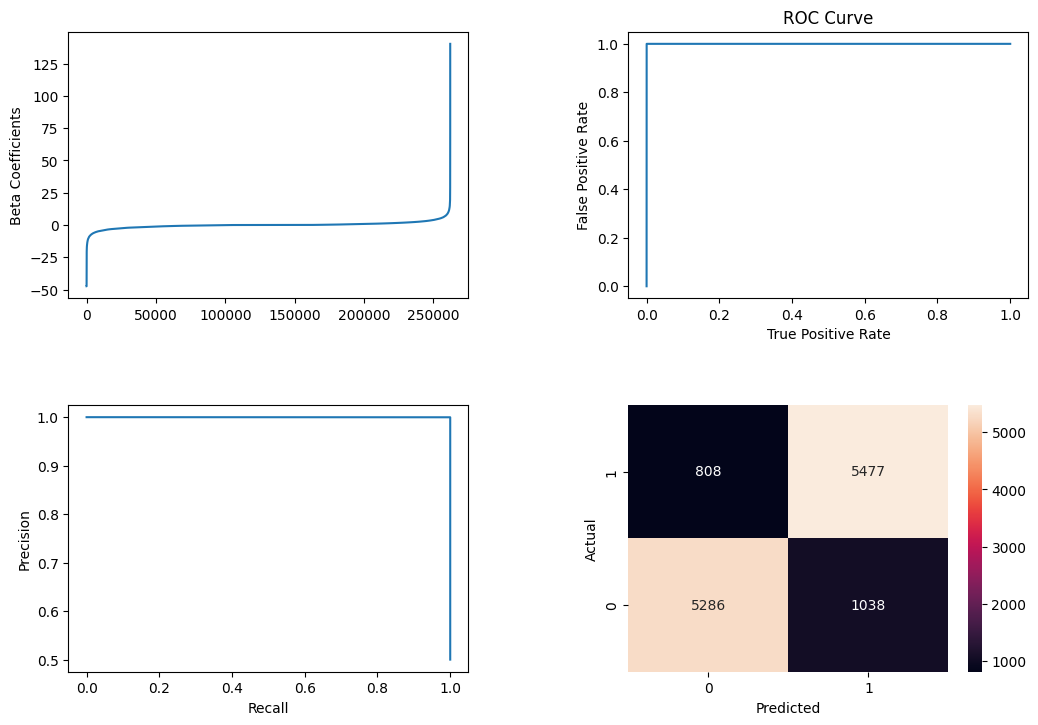

,accuracy,recall_0,recall_1,precision_0,precision_1,true_negatives,false_negatives,true_positives,false_positives,f1
0,0.853597,0.835863,0.87144,0.867411,0.840675,5286,808,5477,1038,0.855781


CPU times: user 4.54 s, sys: 545 ms, total: 5.08 s
Wall time: 10min 26s


In [23]:
%%time

#working with CountVectorizer
count_vec = CountVectorizer(inputCol='refined_tokens',outputCol='features_cv')
cv_text_df = count_vec.fit(refined_text_df).transform(refined_text_df)
model_cv_text_df = cv_text_df.select(['features_cv','token_count','sentiment_index'])
cv_text_df.select(['refined_tokens','token_count','features_cv','sentiment_index']).show(5)

df_assembler = VectorAssembler(inputCols=['features_cv','token_count'],outputCol='features_cv_vec')
model_cv_text_df = df_assembler.transform(model_cv_text_df)
model_cv_text_df.printSchema()

#spliting the dataset
training_df,test_df = model_cv_text_df.randomSplit([0.75,0.25])
trdf = training_df.groupBy('sentiment_index').count().withColumnRenamed('count', 'count_training')
tsdf = test_df.groupBy('sentiment_index').count().withColumnRenamed('count', 'count_test')
trdf = trdf.join(tsdf, 'sentiment_index', how='inner')
print('Distribution of training and test datasets')
trdf.show()


#training and evaluating the model
log_reg = LogisticRegression(featuresCol='features_cv_vec',labelCol='sentiment_index').fit(training_df)
log_reg_preds = log_reg.transform(test_df)
#results = log_reg.evaluate(test_df).predictions
log_reg_preds.show()

lrEval = BinaryClassificationEvaluator(labelCol='sentiment_index')
print('Test Area Under ROC', lrEval.evaluate(log_reg_preds))



beta = np.sort(log_reg.coefficients)
trainingSummary = log_reg.summary
lrROC = trainingSummary.roc.toPandas()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
pr = trainingSummary.pr.toPandas()

#confusion matrix
cm = pyspark_confusion_matrix(log_reg_preds, 'sentiment_index', 'prediction')
metrics = binary_classification_metrics(cm)


print('Plotting')

plt.subplot(221)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

plt.subplot(222)
plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

plt.subplot(223)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.subplot(224)
cmp = cm.iloc[:,1:].values
ax = sns.heatmap(cmp, annot=True,fmt='g')
#ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()


display(pd.DataFrame(metrics))

Calling  HashingTF
+--------------------+---------+---------------+------+--------------------+--------------------+-----------+--------------------+
|              review|sentiment|sentiment_index|length|              tokens|      refined_tokens|token_count|         features_tf|
+--------------------+---------+---------------+------+--------------------+--------------------+-----------+--------------------+
|One of the other ...| positive|            1.0|  1761|[one, of, the, ot...|[one, reviewers, ...|        173|(262144,[3280,436...|
|A wonderful littl...| positive|            1.0|   998|[a, wonderful, li...|[wonderful, littl...|         96|(262144,[120,521,...|
|I thought this wa...| positive|            1.0|   926|[i, thought, this...|[thought, wonderf...|         88|(262144,[1043,139...|
|Basically there's...| negative|            0.0|   748|[basically, there...|[basically, famil...|         74|(262144,[6512,853...|
|Petter Mattei's "...| positive|            1.0|  1317|[petter, 

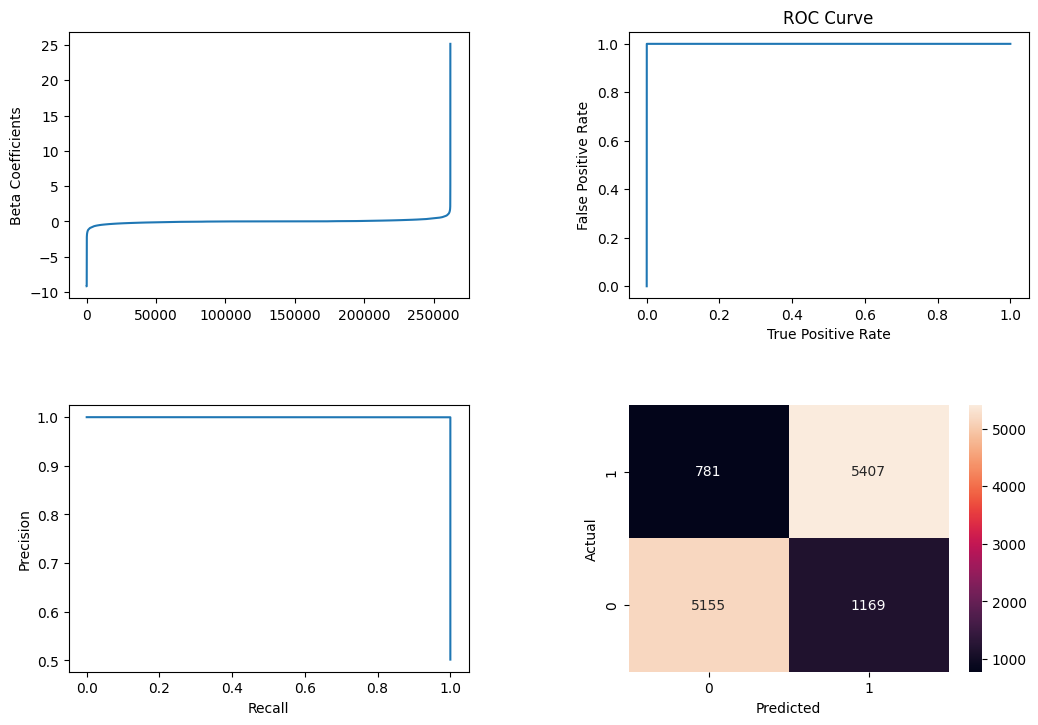

,accuracy,recall_0,recall_1,precision_0,precision_1,true_negatives,false_negatives,true_positives,false_positives,f1
0,0.84415,0.815149,0.873788,0.86843,0.822232,5155,781,5407,1169,0.847227


CPU times: user 4.46 s, sys: 457 ms, total: 4.92 s
Wall time: 10min 10s


In [24]:
%%time

#working with IDF
print('Calling  HashingTF')
hashing_vec = HashingTF(inputCol='refined_tokens',outputCol='features_tf')
hashing_df = hashing_vec.transform(refined_text_df)
hashing_df.show(5)

print('Calling IDF')
tf_idf_vec = IDF(inputCol='features_tf',outputCol='features_tf_idf')
tf_idf_df  = tf_idf_vec.fit(hashing_df).transform(hashing_df)
tf_idf_df.select(['refined_tokens','token_count','features_tf_idf','sentiment_index']).show(5)

model_tfidf_text_df = tf_idf_df.select(['features_tf_idf','token_count','sentiment_index'])


df_assembler = VectorAssembler(inputCols=['features_tf_idf','token_count'],outputCol='features_tfidf_vec')
model_tfidf_text_df = df_assembler.transform(model_tfidf_text_df)
model_tfidf_text_df.printSchema()

#spliting the dataset
training_df,test_df = model_tfidf_text_df.randomSplit([0.75,0.25])
trdf = training_df.groupBy('sentiment_index').count().withColumnRenamed('count', 'count_training')
tsdf = test_df.groupBy('sentiment_index').count().withColumnRenamed('count', 'count_test')
trdf = trdf.join(tsdf, 'sentiment_index', how='inner')
print('Distribution of training and test datasets')
trdf.show()


#training and evaluating the model
log_reg = LogisticRegression(featuresCol='features_tfidf_vec',labelCol='sentiment_index').fit(training_df)
log_reg_preds = log_reg.transform(test_df)
#results = log_reg.evaluate(test_df).predictions
log_reg_preds.show()

lrEval = BinaryClassificationEvaluator(labelCol='sentiment_index')
print('Test Area Under ROC', lrEval.evaluate(log_reg_preds))


beta = np.sort(log_reg.coefficients)
trainingSummary = log_reg.summary
lrROC = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

#confusion matrix
cm = pyspark_confusion_matrix(log_reg_preds, 'sentiment_index', 'prediction')
metrics = binary_classification_metrics(cm)

print('Plotting')
plt.subplot(221)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

plt.subplot(222)
plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

plt.subplot(223)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.subplot(224)
cmp = cm.iloc[:,1:].values
ax = sns.heatmap(cmp, annot=True,fmt='g')
#ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()


display(pd.DataFrame(metrics))